## 畳み込み

畳み込みとは

あるピクセルと隣接するピクセルとの荷重和を作成する計算である。
この計算により、局所的なパターンが画像内の物体位置に関わらず出力に効果的である。

重み行列（カーネル）のスカラー積を出力していく
カーネルサイズは一般的に小さなサイズを使用し、二次元画像には３＊３、RBGの画像には３＊３＊３のカーネルが使用される。

カーネルの重みはnn.Linearの重みと同様に学習してい値である。そしてこのカーネルの重みは画像全体に渡り利用される。
そのためカーネルの重みは画像全体から影響を受けることになる。

全結合層を畳み込みに変更することで、下記のメリットがある

１．近傍における局所的な演算処理
２．移動不変性
３．パラメータを大幅に削減したモデル

## 畳み込みの使用

In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
from torchvision import transforms


from matplotlib import pyplot as plt
import numpy as np

出力チャネルのサイズは任意の値が選択できる。
このチャネルの数が増えるほどパラメータが増加し、特徴量の検出も増大する。

カーネルのサイズはすべての方向に同じことが一般的だが、CTのボクセルのうち一つが異なる解像度であるような場合は、例外的に異なるサイズを使用する。

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
data_path = "../data/p1ch7/"
#引数は保存のパス、訓練用かテスト用か、pytorchで保存して良いか
#他にもSVHN ,COCO,Ominglotなどがある
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10 = datasets.CIFAR10(
            data_path, train=True, download=False, 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                     (0.1470, 0.2435, 0.2626))
            ]))

In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [7]:
#cifar10の中から飛行機と鳥のみのdatasetsにする
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

In [8]:
img, _ = cifar2[0]
img.shape

torch.Size([3, 32, 32])

In [9]:
output = conv(img.unsqueeze(0))
img.unsqueeze((0)).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [10]:
output[0, 0].shape

torch.Size([30, 30])

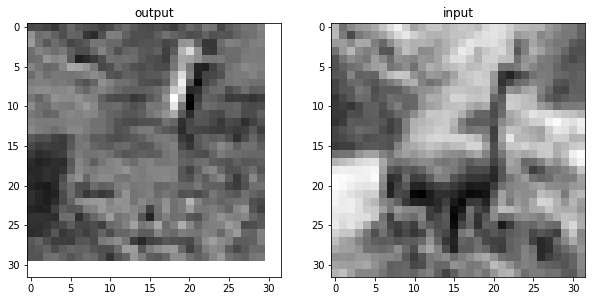

In [11]:
plt.figure(figsize=(10, 4.8))  # 本では省略
ax1 = plt.subplot(1, 2, 1)   # 本では省略
plt.title('output')   # 本では省略
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 本では省略
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  # 本では省略
#plt.savefig('Ch8_F2_PyTorch.png')  # 本では省略
plt.show()

#sharex = XXX：x軸の共有設定
#sharey = XXX：y軸の共有設定

入力に対して出力の画像サイズが小さくなっている。

## 境界のパディング

畳み込み処理では全ての方向に隣接したピクセルが存在する必要がある。
角の位置では上下どちらか、左右どちらかが存在しない。デフォルトではPyTorchではwidth - kernl_width +1 の位置までを取得する。
奇数サイズのカーネルではカーネルの幅の半分（今回は3//2=1)だけ各境界が小さくなった画像が出力された。

pytorchでは畳み込み時に境界領域にゼロになｋる架空のピクセルを作成して画像をパディングできる。
今回の件ではkernel_size=3*3, padeing=1 を指定するともとの画像と同じサイズの出力が得られる。

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

In [13]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

画像サイズが変化しないことはスキップ接続や複雑な構造のモデルでテンソル同士の加減算が可能になる。

## 畳み込みの学習

手動でのパラメータ設定

In [14]:
#バイアスをゼロにする
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [15]:
conv.weight

Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)

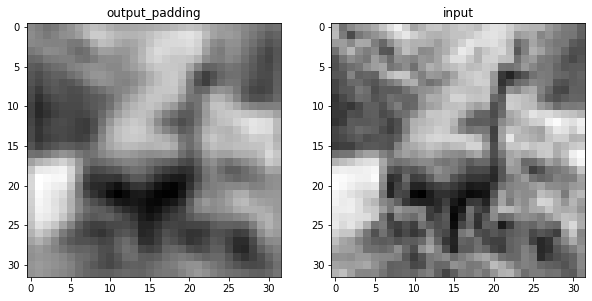

In [16]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # 本では省略
ax1 = plt.subplot(1, 2, 1)   # 本では省略
plt.title('output_padding')   # 本では省略
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 本では省略
plt.imshow(img.mean(0), cmap='gray')  # 本では省略
plt.title('input')  # 本では省略
#plt.savefig('Ch8_F4_PyTorch.png')  # 本では省略
plt.show()

convの一定の重み（フィルタ）によってボケた画像が出力された。
畳み込みは出力ピクセル間に相関が生まれ、スムーズに画像が変化する

In [17]:
conv.weight.shape

torch.Size([1, 3, 3, 3])

In [18]:
#右側のピクセルから左側のピクセルを減算するフィルタ
#強度が異なる領域の垂直方向の境界になっているピクセルに対しては出力の値は大きな値となる。
#一方一様な領域であれば0に近い値となる。

#つまり垂直方向のエッジ検出のカーネルとなる
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [19]:
conv.weight

Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

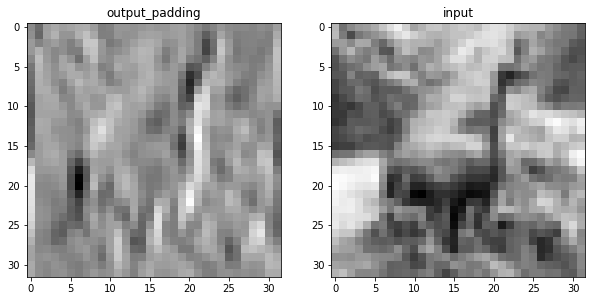

In [20]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # 本では省略
ax1 = plt.subplot(1, 2, 1)   # 本では省略
plt.title('output_padding')   # 本では省略
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 本では省略
plt.imshow(img.mean(0), cmap='gray')  # 本では省略
plt.title('input')  # 本では省略
#plt.savefig('Ch8_F4_PyTorch.png')  # 本では省略
plt.show()

ディープラーニングでは最も効果的なカーネルの値を推定する。
学習は入力と出力の間のクロスエントロピー誤差を最小化するカーネルの値を推測していく。

畳み込みニューラルネットワークは複数チャネルの画像を別の複数チャネルの画像に変換する連続した層のフィルタ群を推定することである。
この異なるチャネルは異なる特徴量に対応する

## 深さとプーリング

CIFAR10の画像は小さく小さなカーネルで局所的な特徴を得た。
大きな画像で広い範囲の構造を把握したい場合はどうすれば良いか？

大きなカーネルを使用することで解決できるが、今度は元々の畳み込みの利点がなくなる。

畳み込みの利点を活かし、かつ大きな範囲の構造も把握するためには畳み込み後に畳み込みを繰り返しその間にダウンサンプリングをする方法がある

## ダウンサンプリング

画像を半分に縮小することは隣接している4つのピクセルを1つのピクセルにする

1.アベレージプーリング
2.マックスプーリング
3.ストライド畳み込み


In [21]:
img.shape

torch.Size([3, 32, 32])

In [22]:
#max_pooling
#画像を半分にしたいときはインスタンス引数に2を入れる

pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape , output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

はじめに小さなカーネルで畳み込みを行い、局所の特徴を掴み、
ダウンサンプリングした縮小後の画像で畳み込みを行う（元の画像で考えると倍の広い領域の特徴を掴む）

1つ目のカーネルは低レベルの特徴を、2つ目のカーネルは広い領域で効果的に動作し、前の特徴量を合成した特徴量を生成する。

このため複雑なケースでも対応できる

In [23]:
# ダウンサンプリングを入れたモデル
model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
)
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [24]:
# 出力は8チャネルの8＊8の画像
model(img.unsqueeze(0)).shape

torch.Size([1, 8, 8, 8])

In [25]:
# 出力はとりか飛行機の2値にする必要がある
# 画像を32のベクトルにして、最後2値にする
model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Linear(8 * 8 * 8, 32),
        nn.Tanh(),
        nn.Linear(32, 2)
)
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [26]:
# パラメータ確認
num_list = [p.numel() for p in model.parameters()]
sum(num_list), num_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
#エラーが出る
#model(img.unsqueeze(0))

## nn.Moduleを継承してモデルを作成

モデル内で入力が二次元から一次元へと形式が変化するような場合はnn.sequeintal()では作成できない
（次元数が変化しないモデルを作成し。最後にLinearする手もある：キカガク参考）

nn.Moduleのサブクラス(子クラス）を用いて作成する

nn.Moduleを用いる場合はfoward関数を定義して、入力か出力への流れを記載する。
backwardはtorchのテンソルでは自動でおこなってくれる。

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# バッチ数が不明のためviewの引数は-1
# CNNの有名なモデルRESNETなどでは解像度を落としながら、チャネルを増やしていく（結果的にはサイズは縮小する）　
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [30]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [31]:
model(img.unsqueeze(0))

tensor([[ 0.1294, -0.1205]], grad_fn=<AddmmBackward0>)

In [32]:
model.train()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

## functional API

パラメータが不要なサブモジュールも上の例ではインスタンス化して登録している。
pytorchでは「内部状態を持たない」といういみのfanctonalAPIが存在し、入力値を引数に入れると出力値が決定するモジュールがある。

nn.Linear には　nn.fanctional.linear 　　重みとバイアスと入力値を引数に入れて出力値が決まる。

In [33]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
                           

In [34]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0529,  0.0507]], grad_fn=<AddmmBackward0>)

## 畳み込みニューラルネットの学習

ネットワークは外側がエポック、内側がバッチを取り出すDataLoaderによって二重にネストされている

各訓練ループは

１．入力をモデルに与える

２．損失を計算する

３．勾配をゼロにする（リセット）

４．loss.backfoward()ですべてのパラメータの損失に対する勾配を計算

５．オプティマイザで損失を低下する方向に更新


In [35]:
#lossまでの確認
img, label = cifar2[0]
label = torch.tensor([label])
label.shape
#labelはバッチ

torch.Size([1])

In [36]:
output = model(img.unsqueeze(0))
output.shape
#outputは バッチ　＊　答えの種類

torch.Size([1, 2])

In [37]:
loss_fn = nn.CrossEntropyLoss()
#確率が高い方のその値とラベルとの損失
loss = loss_fn(output, label)
print(loss, loss.item())

tensor(0.6427, grad_fn=<NllLossBackward0>) 0.6426792144775391


In [38]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            outputs = model(imgs)  # <4>
            loss = loss_fn(outputs, labels)  # <5>
            optimizer.zero_grad()  # <6>            
            loss.backward()  # <7>
            optimizer.step()  # <8>
            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>
            # <1>
# Pythonに含まれているdatetimeモジュールを使用 
# 
# <2>
# 0からではなく1からn_epochsまで数字を振ったエポックに対するループ
# <3>
# データローダーが作成したバッチの中のデータセットに対するループ
# <4>
# モデルにバッチを投入し、…
# <5>
# … そして最小化したい損失を計算を行う。
# <6>
# 直近のラウンドの勾配を取り除いたあとに…
# <7>
# … バックワード処理を行う。 
# つまり、ネットワークに学習して欲しいすべての パラメーターの勾配を計算します。
# <8>
# モデルを更新
# <9>
# エポックをまたいで損失を合算。 
# 勾配の情報を除くため、損失の値を.item()を用いて 
# Pythonの数値に変形するということを覚えておきましょう。 
# <10>
# 訓練用のデータローダーの長さで除算し、バッチあたりの平均損失を得ます。 
# これは合計値よりも直感的な尺度ですね。 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# <1>
# DataLoaderがcifar2のデータセットのサンプルをバッチ化します。 
# また、データセットからサンプルを取得する順番をランダムにシャッフルしています。 
# <2>
# ネットワークをインスタンス化し、…
# <3>
# … 扱った確率的勾配降下の最適化関数を使用し…
# <4>
# … 7.10節で扱った交差エントロピー損失を使用。
# <5>
# 先程定義した訓練ループを呼び出す。 

2022-08-04 07:20:48.352391 Epoch 1, Training loss 0.5983713366043796
2022-08-04 07:21:06.936294 Epoch 10, Training loss 0.32304165659436757
2022-08-04 07:21:28.214782 Epoch 20, Training loss 0.28603252607166385
2022-08-04 07:21:48.568826 Epoch 30, Training loss 0.25668408996929787


訓練の損失は低下したがそれだけでは評価できない

評価指標が必要であるため、正解率で確認してみる

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

import collections

all_acc_dict = collections.OrderedDict()


def validate(model, train_loader, val_loader):
    accdict={}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        # パラメータの更新は不要のためlossは確認しない、勾配も不要

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)


Accuracy train: 0.88
Accuracy val: 0.85


##　モデルの保存と読み込み

In [ ]:
 # モデルの保存
data_path = '.'

torch.save(model.state_dict(), data_path + "birds_vs_airplanes.pt")

この方法でモデルを保存したときはモデル内のパラメータと（重みとバイアス）であって、
モデルの構造は保存されていない。

読み込み時にモデルは同一のモデルをインスタンス化してパラメータを読み込む

In [ ]:
 # モデルの読み込み
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

## GPU上での訓練



.toメソッドを使えばテンソルをGPUへ移動できる。モデルのパラメータもGPUに移し計算をGPU上で行う。

Module.toはそのインスタンスそのものが移動する。

Tensor.toは別メモリ上での処理となり、あらたなテンソルが返される

モデルは適当なデバイスにパラメータを移してからOptimaizerを作成するのがよい。


In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

print(f'Training on device {device}.')        

Training on device cpu.


In [ ]:
# GPUでの学習でも対応
# 全てのパラメータがGPUに無い場合はエラー（一部GPUでの計算は非対応）
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [45]:
model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-08-04 07:21:52.230299 Epoch 1, Training loss 0.6072637319185172
2022-08-04 07:22:11.573403 Epoch 10, Training loss 0.32538400372122506
2022-08-04 07:22:33.067150 Epoch 20, Training loss 0.2949707527069529
2022-08-04 07:22:54.080757 Epoch 30, Training loss 0.2707322500883394


In [46]:
# pytorchではネットワークの重み等の読み込み時は保存時のデバイスに読み込もうとする。
# ネットワークの重みを読み込むデバイスと保存されているデバイスが同じなのか事前には分からないため指示する　map_loacation
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

##　モデルの改善：幅

記憶容量の追加時にハードコーティングを避けるためには、initにパラメータを渡す

In [47]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1 
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-08-04 07:22:58.337797 Epoch 1, Training loss 0.5586554305568622
2022-08-04 07:23:36.593919 Epoch 10, Training loss 0.31862089806681226
2022-08-04 07:24:19.412632 Epoch 20, Training loss 0.2749388356497333
2022-08-04 07:25:07.377365 Epoch 30, Training loss 0.24361977626563638
Accuracy train: 0.88
Accuracy val: 0.78


In [49]:
sum(p.numel() for p in model.parameters())

38386

## 損失時に改善　正則化

損失に正則化項（重みパラメータを足したもの）を加えることで、大きな値の重みへのペナルティになる。
損失関数はより滑らかになり、個々のサンプルに過剰に適合することを防ぐ。

L2：モデル内の重みの二乗をすべて足したもの
重みの減衰（現在の値に比例した量だけ各重みを減衰させる）

L1：モデル内の重みの絶対値をすべて足したもの
重みを0に近づけるため不要なパラメータを無くす

In [50]:
import datetime

def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs +1 ):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.01
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            #l1はpoe(2.0)をabs()
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [51]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-08-04 07:25:13.256518 Epoch 1, Training loss 0.8081606440483384
2022-08-04 07:25:36.446835 Epoch 10, Training loss 0.47865571527724055
2022-08-04 07:26:12.124469 Epoch 20, Training loss 0.4170774420735183
2022-08-04 07:26:35.607158 Epoch 30, Training loss 0.38696237677221845
Accuracy train: 0.87
Accuracy val: 0.84


## ドロップアウト

ネットワーク上の出力をランダムの割合でゼロにする
各反復で異なるニューロンの形状のわずかに異なるモデルが作成されるため、モデル内のニューロンが記憶プロセスになることを防ぐ。

このドロップアウトは訓練時のみ有効であり、推論時はモードを切り替えて全パラメータを使用する。

model.train()

model.eval()

で切り替え

In [52]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-08-04 07:26:41.772915 Epoch 1, Training loss 0.5628887039081306
2022-08-04 07:27:22.552239 Epoch 10, Training loss 0.36985790663084406
2022-08-04 07:28:06.834297 Epoch 20, Training loss 0.34125151252670655
2022-08-04 07:28:51.544297 Epoch 30, Training loss 0.3230181481618031
Accuracy train: 0.86
Accuracy val: 0.84


## バッチ正則化

活性化に対する入力を特定の分布内にリスケールする。
入力が活性化関数の飽和部分へ極端に移動することを防ぎ訓練が遅くなることを防ぐ。

ミニバッチごとにネットワークの中間地点で入力値の平均値と標準偏差を使用して中間入力の大きさにシフトする。

正則化とデータオーギュメンテーションの意味がある

基本的には活性化関数の前に使用

推論時はモードを切り替えることで、訓練時のデータセット全体の平均値と標準偏差を毎回使用するようになる。

In [54]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-08-04 07:29:00.187139 Epoch 1, Training loss 0.4640124616729226
2022-08-04 07:29:51.728797 Epoch 10, Training loss 0.2723110207137029
2022-08-04 07:30:48.898004 Epoch 20, Training loss 0.21426195174360732
2022-08-04 07:31:46.353945 Epoch 30, Training loss 0.17343610022098396
Accuracy train: 0.88
Accuracy val: 0.85


## モデル改善：深さ　スキップ接続

接続の確認

In [ ]:
batch_a = torch.randn(2,1)
batch_b = torch.randn(2,1)
batch_a, batch_b

In [ ]:
batch_a + batch_b

In [ ]:
w = torch.empty(3, 5)
nn.init.constant_(w, 0.5)

ある層の活性化後のの出力を次の層の線形処理後の入力に追加する。

このことで深部の損失の勾配に対する各パラメータの寄与がより直接的になる。
序盤のパラメータの収縮の観点で効果的である。

In [56]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [57]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-08-04 07:55:33.483912 Epoch 1, Training loss 0.6428604524606353
2022-08-04 07:56:09.220229 Epoch 10, Training loss 0.32137808602326995
2022-08-04 07:56:48.922005 Epoch 20, Training loss 0.27012127182286255
2022-08-04 07:57:29.275451 Epoch 30, Training loss 0.23492220419037874
Accuracy train: 0.89
Accuracy val: 0.81


## ディープなモデルを作成するためには

標準的な戦略としては（conv2d,batchnorm,Relu,スキップ接続）のブロックを作成して、
for1ループで動的に繰り返す方法がある。

In [58]:
#ブロックの作成

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        #継承時にsuperの引数は不要だが、多重継承の時に予期せぬ継承がされる可能性があり、引数に指定する
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

# <1>
# BatchNorm層はバイアスの影響を消し去るため、慣例的にバイアスは省いています。 
# <2>
# ResNetの論文で計算されている標準偏差を持つ正規の乱数を用いたカスタマイズの初期化処理 kaiming_normal_initializes を使用します。 
# なお、初期状態では、バッチ正規化処理は平均0で分散0.5の出力分布を生成するように初期化されます。 

ディープに作るためには

resbloksにnn.Sequentialを定義して、指定数＊Resblockを入れる

In [67]:
#リスト
a=(3 * [ResBlock(n_chans=32)])
print(type(a),a)

<class 'list'> [ResBlock(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), ResBlock(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), ResBlock(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


In [65]:
resblocks = nn.Sequential(
           * (3 * [ResBlock(n_chans=32)]))
resblocks

Sequential(
  (0): ResBlock(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ResBlock(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ResBlock(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [68]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-08-04 08:22:35.397013 Epoch 1, Training loss 1.2335678866714428


In [ ]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()
